## Energy minimization for a 2D sheet in 3D

In [2]:
#import tyssue
import sys
#sys.path.append('/home/guillaume/Python/tyssue/src')
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from scipy import optimize

from tyssue.core.sheet import Sheet

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.sheet_vertex_model import SheetModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver

from tyssue import config
import tyssue.dynamics.sheet_isotropic_model as iso
from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.plt_draw import sheet_view
import tyssue.draw.plt_draw as draw
from tyssue.io import hdf5


In [3]:
h5store = '../examples/small_hexagonal.hf5'
#h5store = '../examples/before_apoptosis.hf5'

datasets = hdf5.load_datasets(h5store,
                              data_names=['face', 'vert', 'edge'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)


geom.update_all(sheet)
sheet.vert_df.describe().head(3)


,y,is_active,z,x,rho,old_idx,basal_shift,height,radial_tension
count,9.600000e+01,96.0,9.600000e+01,9.600000e+01,9.600000e+01,96.000000,9.600000e+01,9.600000e+01,96.0
mean,5.181041e-16,1.0,1.656366e-10,-1.526557e-15,5.987904e+00,103.500000,-2.878023e+00,8.865927e+00,0.0
std,4.256314e+00,0.0,7.025397e+00,4.256314e+00,2.259831e-15,27.856777,8.928408e-16,2.564490e-15,0.0


we define the adimentional contractility $\bar\Gamma = \Gamma/K_vA_0h_0^2$ and line tension
$\bar\Lambda = \Lambda /K_v (A_0^{3/2}h_0^2)$, where $h_0$ is such that $V_0 = A_0h_0$.


In [4]:
sheet.face_df.describe().head(3)

,area,z,y,is_alive,x,perimeter,old_idx,num_sides,vol,prefered_area,prefered_vol,contractility,vol_elasticity,prefered_height,basal_shift,basal_height,height,rho
count,56.00000,5.600000e+01,5.600000e+01,56.000000,5.600000e+01,56.000000,56.000000,56.000000,56.000000,56.0,56.0,56.0,56.0,56.0,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01
mean,13.94388,1.892989e-10,5.075305e-16,0.714286,-1.649474e-15,13.143443,27.500000,4.857143,123.625422,24.0,240.0,96.0,1.0,10.0,-3.246161e+00,-3.246161e+00,8.865927e+00,5.987904e+00
std,7.85158,7.368011e+00,4.094538e+00,0.455842,4.094538e+00,4.938941,16.309506,1.823369,69.611531,0.0,0.0,0.0,0.0,0.0,4.481082e-16,4.481082e-16,1.311926e-15,1.672385e-15


In [5]:
sheet.edge_df.describe().head(3)

,dz,length,dx,dy,srce,trgt,face,old_jv0,old_jv1,old_cell,nz,nx,ny,sub_area,sub_vol,line_tension,is_alive
count,272.000000,272.000000,2.720000e+02,2.720000e+02,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,2.720000e+02,2.720000e+02,2.720000e+02,272.000000,272.000000,2.720000e+02,272.000000
mean,0.000000,2.706003,1.632681e-18,3.265362e-18,47.477941,47.477941,27.500000,99.602941,107.352941,27.500000,-5.306213e-17,2.697505e-10,-2.697513e-10,2.870799,25.452293,1.410906e+03,0.882353
std,1.866055,0.005957,1.390566e+00,1.390566e+00,27.725318,27.725318,16.156522,27.179947,27.721741,16.156522,5.921653e-01,4.201581e+00,4.201581e+00,0.801503,7.106068,4.555856e-13,0.322784


## Non dimensionalisation

For our 2D1/2 model, for a tissue energy is expressed as:
$$
E = N_f\frac{K}{2}(V - V_0)^2 + N_f \frac{\Gamma}{2}L^2 + 3N_f\Lambda \ell 
$$
In the case of a regular, infinite hexagonal lattice, There 6 edges per cell, each shared bteween 2 cells, hence $Ne = 3N_f$

We can write this equation as a dimension-less one by dividing it by $N_f K V_0^2$. We define the dimension-less values: $\bar\Gamma = \Gamma/K V_0^{4/3}$ and $\bar\Lambda = \Lambda/K V_0^{5/3}$

$$
\bar{E} = \frac{\left(V/V_0 - 1\right)^2}{2} + \bar\Gamma \frac{V_0^{-2/3}}{2}L^2 + 3\bar\Lambda V_0^{-1/3} \ell
$$

We define the scaling factor $\delta$ such that $V/V_0 = \delta^3$. On a regular hexagonal grid, the perimeter $L=6\ell$ and the area is A=$3\sqrt{3}/2$. The volume is $V = Ah$. We define the aspect-ratio: $\alpha = \frac{3\sqrt{3}}{2}h/\ell$, so that $V = \alpha \ell^3$ and $V_0 = \alpha \ell^3 / \delta^3$. Substituting those values in the above equations:

$$
\begin{eqnarray}
\bar{E} &=& \frac{(\delta^3 - 1)^2}{2} + 18\bar\Gamma \alpha^{-2/3}\delta^2 + 3\bar\Lambda \alpha^{-1/3} \delta \\
\bar{E} &=& \delta^6/2 -\delta^3 + 1/2 + 18\bar\Gamma \alpha^{-2/3}\delta^2 + 3\bar\Lambda \alpha^{-1/3} \delta \\
\end{eqnarray}
$$


The root of this polynomial corresponds to the lowest energy possible for this set of paramters. As expected, the relative importance of the volume elasticity to the apical forces increases as the aspect ratio grows.  






In [1]:
nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimensionalize(nondim_specs)

sheet.update_specs(dim_model_specs, reset=True)
isotropic_relax(sheet, nondim_specs)

NameError: name 'config' is not defined

In [6]:
Et, Ec, Ev = model.compute_energy(sheet, full_output=True)
energy = model.compute_energy(sheet, full_output=False)
print('Total energy: {}'.format(energy))

Total energy: 19.157287217653735


0.886592687387 0.967346938776


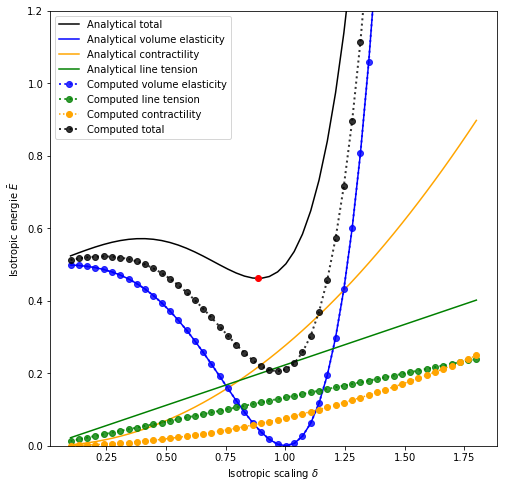

In [7]:
from tyssue.draw.plt_draw import plot_analytical_to_numeric_comp
fig, ax = plot_analytical_to_numeric_comp(sheet, model, geom,
                                          iso, nondim_specs)


In [10]:
nondim_specs

{'edge': {'is_active': 1,
  'line_tension': 0.12,
  'ux': 0.0,
  'uy': 0.0,
  'uz': 0.0},
 'face': {'contractility': 0.04,
  'prefered_area': 12.0,
  'prefered_height': 24.0,
  'prefered_vol': 288.0,
  'vol_elasticity': 1.0},
 'settings': {'grad_norm_factor': 1.0, 'nrj_norm_factor': 1.0},
 'vert': {'is_active': 1, 'radial_tension': 0.0}}

In [8]:
dim_model_specs

{'edge': {'is_active': 1,
  'line_tension': 1507.1925045186904,
  'ux': 0.0,
  'uy': 0.0,
  'uz': 0.0},
 'face': {'contractility': 76.076403814532171,
  'prefered_area': 12.0,
  'prefered_height': 24.0,
  'prefered_vol': 288.0,
  'vol_elasticity': 1.0},
 'settings': {'grad_norm_factor': 1.0, 'nrj_norm_factor': 82944.0},
 'vert': {'is_active': 1, 'radial_tension': 0.0}}

In [8]:
model.compute_energy(sheet) / sheet.face_df.is_alive.sum()

0.22461813180046267

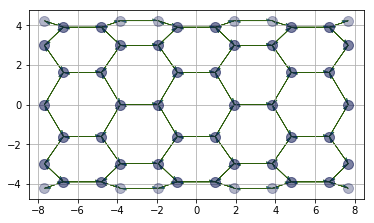

In [9]:
isotropic_relax(sheet, nondim_specs)

fig, ax = sheet_view(sheet, ['z', 'x'])

In [10]:
model.labels

['Line tension', 'Contractility', 'Volume elasticity']

In [11]:
gradients = model.compute_gradient(sheet, components=True)
gradients = {label: (srce, trgt) for label, (srce, trgt)
             in zip(model.labels, gradients)}
gradients['Line tension'][0].head()

,gx,gy,gz
edge,,,
0,-0.000000,0.000000,0.000000
1,-0.000000,0.000000,-0.000000
2,127.116863,-639.059628,-378.617758
3,-127.116863,-639.059628,378.617758
4,-0.000000,-0.000000,-753.596252


In [12]:
grad_i = model.compute_gradient(sheet, components=False)
grad_i.head()

,gx,gy,gz
srce,,,
0,-0.001853,8.223874e-18,0.016352
1,-0.013676,-5.664747e-03,0.017470
2,-0.001310,-1.310225e-03,0.016352
3,-0.013676,5.664747e-03,0.017470
4,-0.015388,6.373836e-03,-0.001118


In [13]:
geom.scale(sheet, 2, sheet.coords)
geom.update_all(sheet)

In [14]:
bck_lt = sheet.edge_df.line_tension.copy()
bck_ct = sheet.face_df.contractility.copy()
bck_ve = sheet.face_df.vol_elasticity.copy()


In [15]:
# sheet.edge_df.line_tension = 0
# sheet.face_df.vol_elasticity = 0
# sheet.face_df.contractility = 0

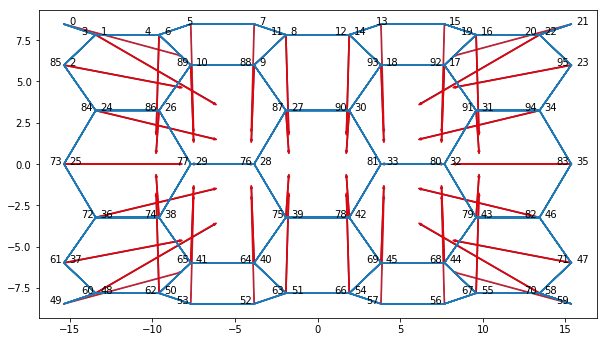

In [17]:
scale = 10
fig, ax = draw.plot_forces(sheet, geom, model, ['z', 'x'], scale)
fig.set_size_inches(10, 12)
for n, (vx, vy, vz) in sheet.vert_df[sheet.coords].iterrows():
    shift = 0.6 * np.sign(vy)
    ax.text(vz+shift-0.3, vx, str(n))

app_grad_specs = config.draw.sheet_spec()['grad']
app_grad_specs.update({'color':'r'})
    
def draw_approx_force(ax=None):
    fig, ax = draw.plot_forces(sheet, geom, model,
                              ['z', 'x'], scaling=scale, ax=ax,
                              approx_grad=solver.approx_grad, **{'grad':app_grad_specs})
    fig.set_size_inches(10, 12)
    return fig, ax

## Uncomment bellow to recompute
fig, ax = draw_approx_force(ax=ax)
#fig

In [18]:
sheet.coords

['x', 'y', 'z']

In [19]:
sheet.edge_df.line_tension = bck_lt.copy()
sheet.face_df.contractility = bck_ct.copy()
sheet.face_df.vol_elasticity = bck_ve.copy()

http://scipy.github.io/devdocs/generated/scipy.optimize.check_grad.html#scipy.optimize.check_grad

In [20]:

grad_err = solver.check_grad(sheet, geom, model)
grad_err /= sheet.vert_df.size


print("Error on the gradient (non-dim, per vertex): {:.3e}".format(grad_err))


Error on the gradient (non-dim, per vertex): 3.993e-05


In [22]:
settings = {
    'minimize': {
        'options': {'disp':False,
                    'ftol':1e-5,
                    'gtol':1e-5},
        }
    }


res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])

True


In [23]:
res['message']

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [24]:
res['fun']/sheet.face_df.is_alive.sum()

0.19599116422873999

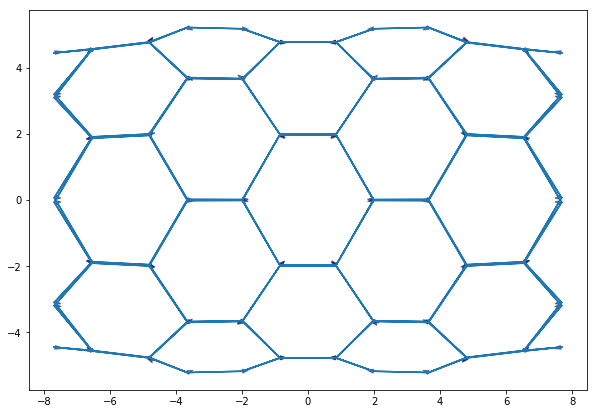

In [25]:
fig, ax = draw.plot_forces(sheet, geom, model, ['z', 'y'], 10)
fig.set_size_inches(10, 12)
